# Chapter 6

In [199]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import ptitprince as pt
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
import networkx as nx

In [2]:
az.style.use('arviz-darkgrid')

simulating selection distortion:

In [22]:
N = 200          # Number of grant proposals
p = 0.1          # chance to select
nw = stats.norm.rvs(size= N)    #newsworthiness
tw = stats.norm.rvs(size = N)   #trustworthiness
s = nw + tw                     # total score
q = np.quantile(s, 1-p)         # top 10% combined score

In [23]:
df = pd.DataFrame([nw,tw]).T

In [24]:
df.columns=['newsworthiness', 'trustworthiness']

In [25]:
df['s'] = nw + tw

In [26]:
df_selected = df[df['s']>=q]

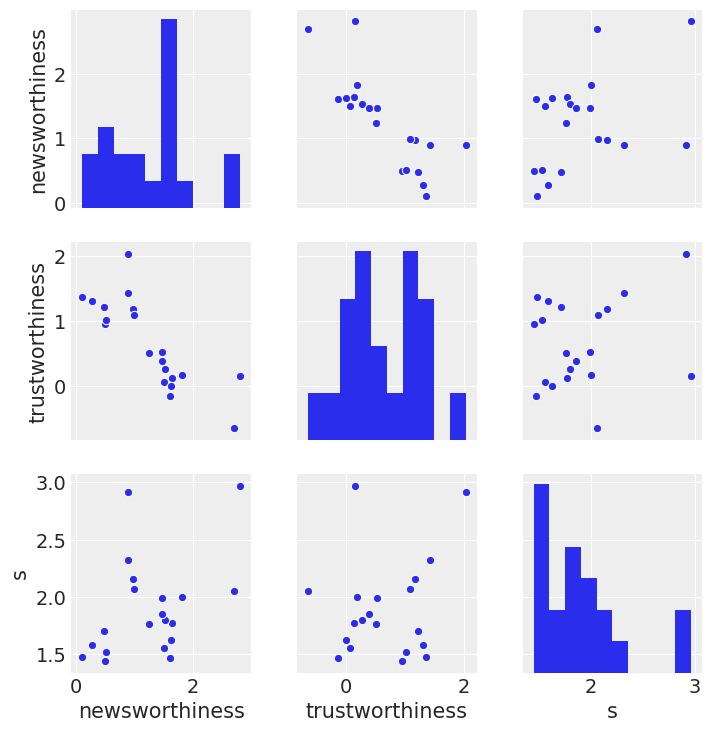

In [27]:
sns.pairplot(df_selected)

Multicolinear legs

In [128]:
N = 1000                                                  #number of individuals
height =stats.norm.rvs(10,2, size = N)                            #total height of individuals
prop_leg = stats.uniform.rvs(0.4, 0.1, size = N)
leg_left = prop_leg * height + stats.norm.rvs(0, 0.02, size = N)
leg_right = prop_leg * height + stats.norm.rvs(0, 0.02, size = N)
df  = pd.DataFrame([height, leg_left, leg_right]).T

In [129]:
df. columns = ['height', 'leg_left', 'leg_right']

In [130]:
df['proportion'] = df['height']/4.5

In [131]:
df['proportion'].mean()

2.2170410501632705

In [132]:
with pm.Model() as m61:
    sigma = pm.Exponential('sigma', 1)
    br = pm.Normal('br', 2, 10)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * df['leg_left'] + br* df['leg_right'])
    height = pm.Normal('height', mu, sigma, observed = df['height'])
    trace61 = pm.sample(1000, tune= 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 8000/8000 [03:28<00:00, 11.70draws/s]


In [133]:
pm.summary(trace61, varnames = ['br','bl','a','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
br,1.234691,0.689751,0.017331,-0.140202,2.549315,1513.677676,1.000034
bl,0.774415,0.690588,0.017342,-0.541972,2.151425,1512.083014,1.000042
a,0.966866,0.088421,0.001840,0.798019,1.139185,2704.198610,0.999669
sigma,0.590277,0.013225,0.000244,0.565549,0.617755,2507.293598,0.999681


GridSpec(1, 2, width_ratios=[3, 1])

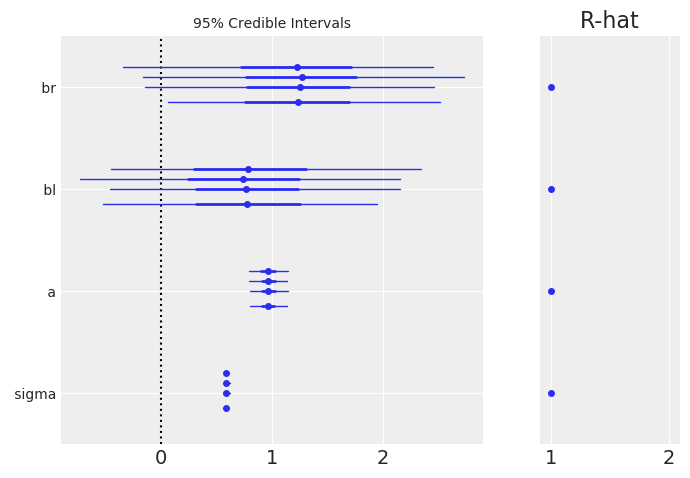

In [134]:
pm.forestplot(trace61, varnames = ['br','bl','a','sigma'])

In [135]:
np.mean(trace61.br+trace61.bl)

2.009106139203996

In [142]:
az.plot_kde(trace61.br+trace61.bl)

AttributeError: 'MultiTrace' object has no attribute 'br'

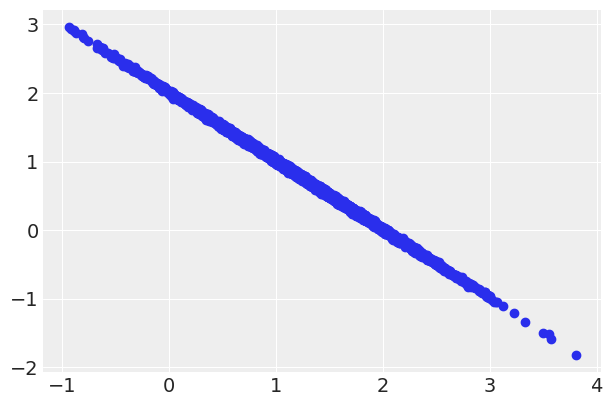

In [136]:
plt.scatter(trace61.br, trace61.bl)

In [137]:
with pm.Model() as m61:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * df['leg_left'])
    height = pm.Normal('height', mu, sigma, observed = df['height'])
    trace61 = pm.sample(1000, tune= 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:17<00:00, 462.30draws/s]
The acceptance probability does not match the target. It is 0.8790489335353132, but should be close to 0.8. Try to increase the number of tuning steps.


GridSpec(1, 2, width_ratios=[3, 1])

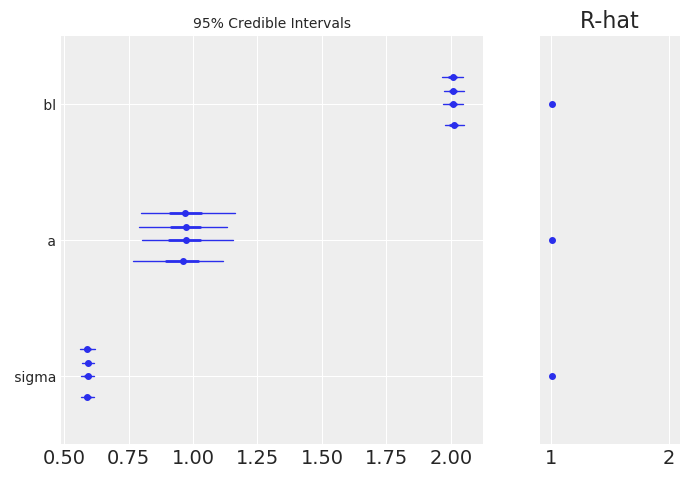

In [138]:
pm.forestplot(trace61, varnames = ['bl','a','sigma'])

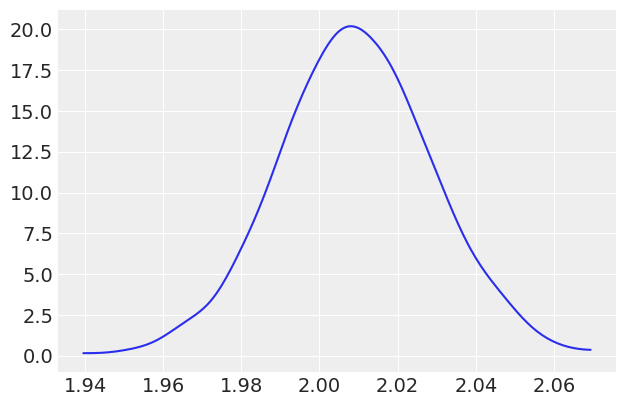

In [139]:
az.plot_kde(trace61.bl)

In [140]:
pm.summary(trace61, varnames = ['bl','a','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bl,2.008766,0.019559,0.000522,1.971185,2.048933,1432.090270,1.001752
a,0.967463,0.089625,0.002387,0.784409,1.140035,1447.973560,1.001764
sigma,0.590845,0.013118,0.000281,0.565155,0.616203,2052.411045,1.001801


In [3]:
df = pd.read_csv('../resources/Rethinking/Data/milk.csv', sep = ';')

In [4]:
df['K'] = pre.scale(df['kcal.per.g'])
df['F'] = pre.scale(df['perc.fat'])
df['L'] = pre.scale(df['perc.lactose'])

In [5]:
with pm.Model() as K_on_F:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    bf = pm.Normal('bf', 0, 0.5)
    mu = pm.Deterministic('mu', alpha + bf * df['F'])
    K = pm.Normal('K', mu, sigma, observed = df['K'])
    traceKF = pm.sample(1000, tune = 1000)
    


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '27148' (I am process '25848')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bf, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1064.23draws/s]


In [10]:
with pm.Model() as K_on_L:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    bl = pm.Normal('bl', 0, 0.5)
    mu = pm.Deterministic('mu', alpha + bl * df['L'])
    K = pm.Normal('K', mu, sigma, observed = df['K'])
    traceKL = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bl, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1026.39draws/s]


In [12]:
pm.summary(traceKF, varnames = ['alpha', 'bf', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.000363,0.082305,0.001244,-0.158690,0.160964,5517.404516,0.999989
bf,0.858488,0.091387,0.001387,0.680831,1.037136,4050.484791,0.999583
sigma,0.495860,0.070299,0.001085,0.374806,0.645770,4384.551139,0.999553


In [14]:
pm.summary(traceKL, varnames = ['alpha', 'bl', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.000260,0.072408,0.001075,-0.153276,0.135163,5904.483674,1.000021
bl,-0.900050,0.075746,0.001248,-1.050806,-0.755441,4356.946872,0.999774
sigma,0.418466,0.057299,0.000907,0.312530,0.529398,3988.678600,1.000010


In [21]:
df_pairplot = pd.DataFrame([df['K'], df['F'], df['L']]).T

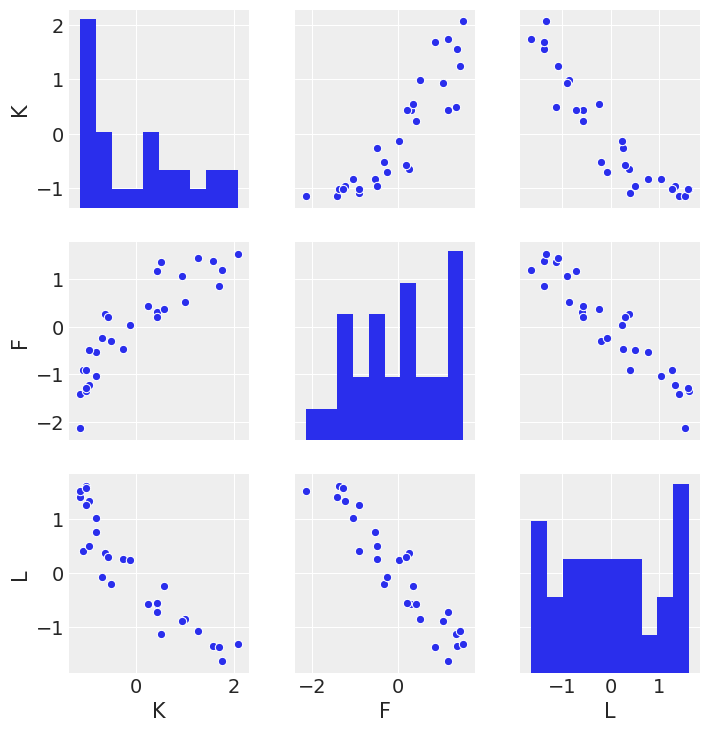

In [22]:
sns.pairplot(df_pairplot)

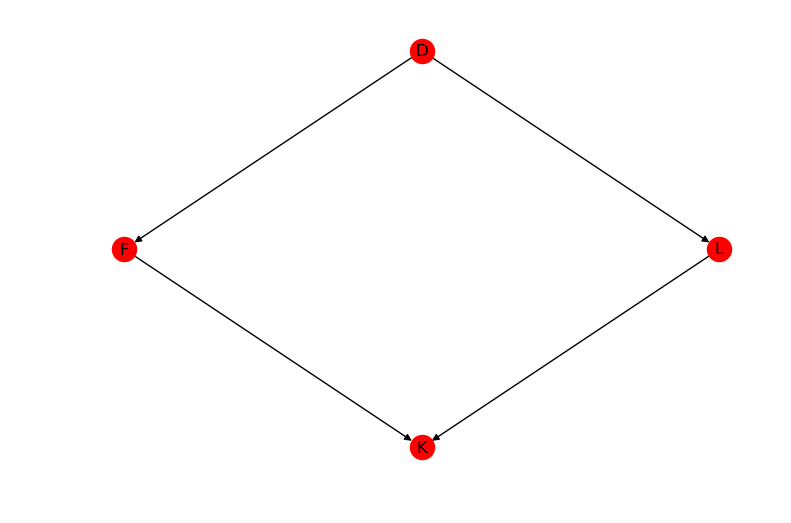

In [32]:
G = nx.DiGraph()
G.add_nodes_from(['L', 'D', 'F', 'K'])
G.add_edge('D','L')
G.add_edge('D', 'F')
G.add_edge('L', 'K')
G.add_edge('F', 'K')
nx.draw_circular(G, with_labels = True)

In [33]:
with pm.Model() as K_on_FL:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    bf = pm.Normal('bf', 0, 0.5)
    bl = pm.Normal('bl', 0, 0.5)
    mu = pm.Deterministic('mu', alpha + bf * df['F'] + bl * df['L'])
    K = pm.Normal('K', mu, sigma, observed = df['K'])
    traceKFL = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bl, bf, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:11<00:00, 695.30draws/s]


In [47]:
varnames = ['~mu']

In [49]:
az.summary(traceKFL, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.074,-0.137,0.140,0.001,0.001,2582.0,1525.0,2612.0,2335.0,1.0
bf,0.248,0.192,-0.108,0.609,0.004,0.003,2011.0,1869.0,2026.0,2208.0,1.0
bl,-0.672,0.194,-1.041,-0.303,0.004,0.003,1960.0,1960.0,1974.0,2148.0,1.0
sigma,0.421,0.061,0.314,0.528,0.001,0.001,2815.0,2738.0,2947.0,2376.0,1.0


In [54]:
df.L.corr(df.F)

-0.941637345683928

In [4]:
import statsmodels.formula.api as smf

In [5]:
def simcoll(r=0.9):
    df['x'] = stats.norm.rvs(loc = df['perc.fat'], scale = np.sqrt((1-r**2) * df['perc.fat'].var()), size = len(df))
    X = np.column_stack((df['perc.fat'], df['x']))
    m = smf.OLS(df['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return(np.diag(cov)[1])**0.5

In [6]:
def repsimcoll(r=0.9, N=100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

In [7]:
lista = np.linspace(0,0.99,99)
result = [repsimcoll(r=x) for x in lista]

NameError: name 'df' is not defined

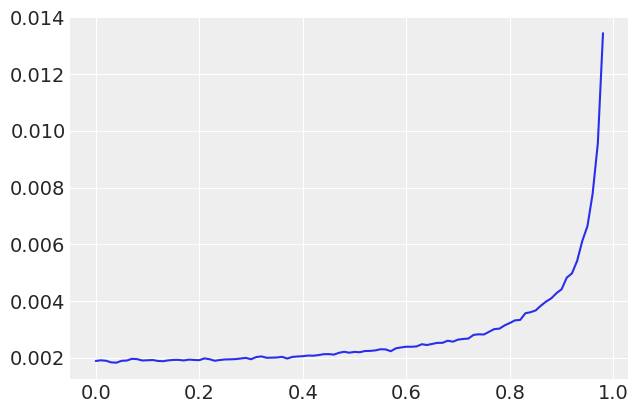

In [82]:
plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), result)

In [3]:
#number of plants
N = 100

#simulate initial heights
h_0 = stats.norm.rvs(10,2,N)

#assign treatments and simulate fungus and growth
treatment = np.repeat([0,1],N/2)
fungus = stats.binom.rvs(1,p=0.5-treatment*0.4, size = N)
h_1 =h_0 + stats.norm.rvs(5-3*fungus, size = N)

df = pd.DataFrame([h_0, h_1, treatment, fungus]).T
df.columns = ['h_0', 'h_1', 'treatment', 'fungus']

In [4]:
df.describe()

,h_0,h_1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.823755,13.595981,0.500000,0.380000
std,2.068613,2.774631,0.502519,0.487832
min,3.693575,6.117885,0.000000,0.000000
25%,8.482750,12.065449,0.000000,0.000000
50%,10.097355,14.159322,0.500000,0.000000
75%,11.011665,15.618370,1.000000,1.000000
max,15.789707,19.324036,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE541DFF28>,
      dtype=object)

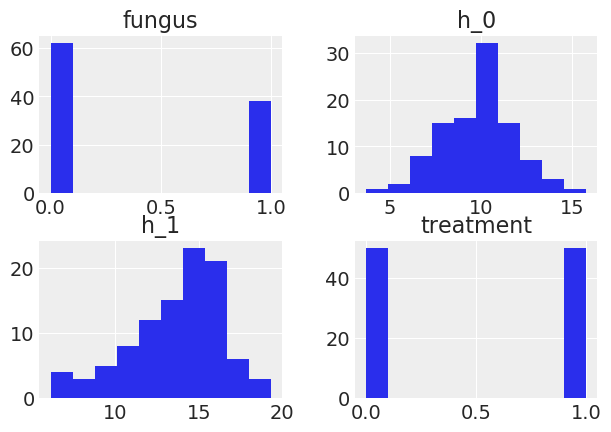

In [5]:
df.hist()

$$ h_{i,1} \sim N(\mu_i, \sigma) $$
$$ \mu_i = ph_{0,i} $$

In [12]:
with pm.Model() as m66:
    sigma = pm.Exponential('sigma',1)
    p = pm.Lognormal('p', 0, 0.25)
    mu =  pm.Deterministic('mu', p * df['h_0'])
    h_1 = pm.Normal('h1', mu,sigma, observed = df.h_1)
    t66 = pm.sample(1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1899.66draws/s]


In [13]:
az.summary(t66, var_names = ['~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,1.845,0.127,1.605,2.075,0.002,0.001,3820.0,3748.0,3900.0,2877.0,1.0
p,1.368,0.019,1.330,1.400,0.000,0.000,3972.0,3972.0,3982.0,2706.0,1.0


In [15]:
with pm.Model() as m67:
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Lognormal('alpha', 0, 0.25)
    beta_t = pm.Normal('beta_t', 0,0.5)
    beta_f = pm.Normal('beta_f', 0,0.5)
    p = pm.Deterministic('p', alpha + beta_t * df['treatment'] + beta_f * df['fungus'])
    mu =  pm.Deterministic('mu', p * df['h_0'])
    h_1 = pm.Normal('h1', mu,sigma, observed = df.h_1)
    t67 = pm.sample(1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_f, beta_t, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1326.49draws/s]


In [18]:
az.summary(t67, var_names = ['~p', '~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_t,-0.025,0.027,-0.074,0.028,0.001,0.000,1663.0,1663.0,1661.0,2692.0,1.01
beta_f,-0.295,0.029,-0.350,-0.241,0.001,0.000,1970.0,1970.0,1991.0,2193.0,1.00
sigma,1.211,0.087,1.056,1.381,0.002,0.001,2927.0,2854.0,3001.0,2404.0,1.00
alpha,1.494,0.024,1.446,1.537,0.001,0.000,1600.0,1600.0,1594.0,2213.0,1.01


In [19]:
with pm.Model() as m68:
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Lognormal('alpha', 0, 0.25)
    beta_t = pm.Normal('beta_t', 0,0.5)
    p = pm.Deterministic('p', alpha +  beta_t * df['treatment'])
    mu =  pm.Deterministic('mu', p * df['h_0'])
    h_1 = pm.Normal('h1', mu,sigma, observed = df.h_1)
    t67 = pm.sample(1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1556.04draws/s]


In [20]:
az.summary(t67, var_names = ['~p', '~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_t,0.120,0.035,0.056,0.187,0.001,0.001,2121.0,1983.0,2114.0,2257.0,1.0
sigma,1.760,0.124,1.542,1.990,0.002,0.002,2591.0,2572.0,2634.0,2675.0,1.0
alpha,1.309,0.025,1.264,1.360,0.001,0.000,2281.0,2281.0,2294.0,2419.0,1.0


In [33]:
G = nx.DiGraph()

In [114]:
G.add_nodes_from(['H0', 'H1', 'F', 'T'])
G.add_edge('H0', 'H1')
G.add_edge('T', 'F' )
G.add_edge('F', 'H1')

In [90]:
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
P = nx.drawing.nx_pydot.to_pydot(G)

In [197]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

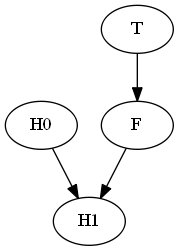

In [92]:
view_pydot(P)

In [214]:
G=nx.DiGraph()

In [215]:
G.add_nodes_from(['T','S','N'])

In [216]:
G.add_edge('T','S')
G.add_edge('N','S')

In [217]:
P = nx.drawing.nx_pydot.to_pydot(G)

In [219]:
import graphviz

In [186]:
G=nx.DiGraph()

In [191]:
G.add_nodes_from(['S','W','A','M','D'])
G.add_edge('S','M')
G.add_edge('S','W')
G.add_edge('S','A')
G.add_edge('A','M')
G.add_edge('A','D')
G.add_edge('M','D')
G.add_edge('W','D')

In [196]:
P = nx.drawing.nx_pydot.to_pydot(G)

In [223]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')

In [224]:
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

In [225]:
print(dot.source)

// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}


In [226]:
print(P)    

strict digraph  {
T;
S;
N;
T -> S;
N -> S;
}



In [227]:
dot.render('test-output/round-table.gv', view=True)

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'round-table.gv'], make sure the Graphviz executables are on your systems' PATH